In [1]:
import pandas as pd
import os
import re
import time
import numpy as np
import statistics
from natsort import natsorted, ns
import random
from sklearn.preprocessing import StandardScaler 

from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from xgboost import XGBClassifier

import networkx as nx
from networkx import ego_graph

import torch.optim as optim
import argparse
import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, SAGEConv, GINConv

from ogb.nodeproppred import PygNodePropPredDataset, Evaluator

#from logger import Logger
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid,WebKB
from torch_geometric.datasets import WikipediaNetwork
from torch_geometric.loader import DataLoader

In [4]:
def spatial_two(Node_class, Edge_indices, n):
    F_vec = []
    for i in range(n):
        print("\rProcessing file {} ({}%)".format(i, 100*i//(n-1)), end='', flush=True)
        node_F = []
        list_out = []
        list_In = []
        S_nbd_out = []
        S_nbd_in = []
        for edge in Edge_indices:
            src, dst = edge
            if src == i:
                list_out.append(label[dst])
                for edge_2 in Edge_indices:
                    src_2, dst_2 = edge_2
                    if src_2 == dst and src_2 != dst_2:
                        S_nbd_out.append(label[dst_2])

        #print(list_out)
        #print(list_In)
        for d in Node_class:
            count = 0
            count_in = 0
            
            for node in list_out:
                if Node_class[node] == d:
                    count += 1
            node_F.append(count)

        F_vec.append(node_F)
    return F_vec


In [10]:
def spatial_two(Node_class, Edge_indices, n):
    F_vec = []
    for i in range(n):
        print("\rProcessing file {} ({}%)".format(i, 100*i//(n-1)), end='', flush=True)
        node_F = []
        list_out = []
        list_In = []
        S_nbd_out = []
        S_nbd_in = []
        for edge in Edge_indices:
            src, dst = edge
            if src == i:
                list_out.append(int(label[dst]))
                for edge_2 in Edge_indices:
                    src_2, dst_2 = edge_2
                    if src_2 == dst and src_2 != dst_2:
                        S_nbd_out.append(int(label[dst_2]))

        #print(list_out)
        #print(S_nbd_out)
        #List=np.concatenate((list_out, S_nbd_out),dtype=int)
        List=list_out+S_nbd_out
        #print(List)
        for d in Node_class:
            count = 0
            count_in = 0
            
            for node in List:
            #for node in S_nbd_out:
                if Node_class[node] == d:
                    count += 1
            node_F.append(count)

        F_vec.append(node_F)
    return F_vec

In [5]:
dataset = Planetoid(root='/tmp/cora', name='Cora',split='geom-gcn')
data = dataset[0]
print(data)
train_index = np.where(data.train_mask)[0]
print(len(train_index))
valid_index = np.where(data.val_mask)[0]
print(len(valid_index))
test_index = np.where(data.test_mask)[0]
print(len(test_index))

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708, 10], val_mask=[2708, 10], test_mask=[2708, 10])
11920
7960
4970


In [6]:
Number_nodes=2708
label=data.y.numpy()
Edge_idx=data.edge_index.numpy()
Node=range(Number_nodes)
Edgelist=[]
for i in range(len(Edge_idx[1])):
    Edgelist.append((Edge_idx[0][i],Edge_idx[1][i]))

In [7]:
Node_class=[0,1,2,3,4,5,6]
F_vec=spatial_two(Node_class, Edgelist,Number_nodes)

Processing file 2707 (100%)

In [33]:
x =np.array(F_vec)
k=len(F_vec[0])
feature=[]
for i in range(len(x[0])):
    feature.append("{}".format(i))
data_s=pd.DataFrame(x,columns =feature)
data_s.insert(loc=k,column='class',value=label)
data_s.head()

,0,1,2,3,4,5,6,class
0,0,0,0,3,0,0,0,3
1,0,0,0,0,3,0,0,4
2,0,0,0,3,2,0,0,4
3,1,0,0,0,0,0,0,0
4,0,0,2,3,0,0,0,3


In [34]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
data_by_class = {cls: data_s.loc[data_s['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}


In [35]:
Homophily_Matrix=[]
for i in range(7):
    df=data_by_class[i].div(data_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    Homophily_Matrix.append(column_avg)
print(Homophily_Matrix)
diagonal_elements = np.diag(Homophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Spatial Homophily_Ratio:", Homophily_Ratio)

[[0.7433252651965695, 0.029202064345352427, 0.013672957677482563, 0.08327479381726012, 0.05031087849288477, 0.03675484292628588, 0.04345919754416488], [0.03983157779240729, 0.7686691036667317, 0.06214285906106182, 0.07999419934903805, 0.020205731175845027, 0.027620430644624192, 0.0015360983102918587], [0.009894312226848112, 0.024732544170343217, 0.916962929241898, 0.0322403374137824, 0.0011961722488038277, 0.014375618573923131, 0.0005980861244019139], [0.055408348412788, 0.019705140854285107, 0.016183191977813004, 0.8385238729917665, 0.05123473928807863, 0.015184567537868272, 0.0037601389374005514], [0.05769850584991428, 0.014115891932793343, 0.0016431924882629107, 0.06356587235833298, 0.8488417285175781, 0.01092108204784261, 0.003213726805276101], [0.05760052228087209, 0.016996095265439916, 0.03032882616133702, 0.05134507966205643, 0.017902731562423627, 0.7855714732418333, 0.04025527182603771], [0.11298147549279411, 0.0009096816114359974, 0.002962962962962963, 0.02214424951267057, 0.0

In [14]:
data = Homophily_Matrix
# Convert each number to 3 decimal points
formatted_data = [[f'{num:.3f}' for num in row] for row in data]

# Convert the formatted data to a LaTeX table
latex_table = '\\begin{tabular}{|' + '|'.join(['c'] * len(formatted_data[0])) + '|}\n'
latex_table += '\\hline\n'
for row in formatted_data:
    latex_table += ' & '.join(row) + ' \\\\\n'
latex_table += '\\hline\n\\end{tabular}'

print(latex_table)


\begin{tabular}{|c|c|c|c|c|c|c|}
\hline
0.743 & 0.029 & 0.014 & 0.083 & 0.050 & 0.037 & 0.043 \\
0.040 & 0.769 & 0.062 & 0.080 & 0.020 & 0.028 & 0.002 \\
0.010 & 0.025 & 0.917 & 0.032 & 0.001 & 0.014 & 0.001 \\
0.055 & 0.020 & 0.016 & 0.839 & 0.051 & 0.015 & 0.004 \\
0.058 & 0.014 & 0.002 & 0.064 & 0.849 & 0.011 & 0.003 \\
0.058 & 0.017 & 0.030 & 0.051 & 0.018 & 0.786 & 0.040 \\
0.113 & 0.001 & 0.003 & 0.022 & 0.006 & 0.067 & 0.788 \\
\hline
\end{tabular}


In [14]:
def Similarity(array1, array2):
    intersection = np.sum(np.logical_and(array1, array2))
    return intersection

In [18]:
import pandas as pd
dataset = Planetoid(root='/tmp/cora', name='Cora')
data = dataset[0]
Domain_Fec=pd.DataFrame(data.x.numpy())
label=pd.DataFrame(data.y.numpy(),columns =['class'])
Data=pd.concat([Domain_Fec,label], axis=1)
Data.head()

,0,1,2,3,4,5,6,7,8,9,...,1424,1425,1426,1427,1428,1429,1430,1431,1432,class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


In [19]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=Data['class'].to_numpy()
data_by_class = {cls: Data.loc[Data['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
basis = [[max(df[i]) for i in range(len(df.columns))] for df in data_by_class.values()]
sel_basis = [[int(list(df[i].to_numpy()).count(1) >= int(len(df[i].index)*0.1)) 
              for i in range(len(df.columns))]
             for df in data_by_class.values()]
feature_names = [ii for ii in range(fe_len)]

In [11]:
Fec=[]
for i in range(Number_nodes):
#for i in range(2):
    vec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    vec.append(Similarity(f,basis[0]))
    vec.append(Similarity(f,basis[1]))
    vec.append(Similarity(f,basis[2]))
    vec.append(Similarity(f,basis[3]))
    vec.append(Similarity(f,basis[4]))
    vec.append(Similarity(f,basis[5]))
    vec.append(Similarity(f,basis[6]))
    f.clear()
    Fec.append(vec)
SFec=[]
for i in range(Number_nodes):
#for i in range(2):
    Svec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    Svec.append(Similarity(f,sel_basis[0]))
    Svec.append(Similarity(f,sel_basis[1]))
    Svec.append(Similarity(f,sel_basis[2]))
    Svec.append(Similarity(f,sel_basis[3]))
    Svec.append(Similarity(f,sel_basis[4]))
    Svec.append(Similarity(f,sel_basis[5]))
    Svec.append(Similarity(f,sel_basis[6]))
    f.clear()
    SFec.append(Svec)

NameError: name 'Data' is not defined

In [21]:
Fe=[]
for i in range(7):
    Fe.append("S_{}".format(i))
Z =np.array(SFec)
data_2 = pd.DataFrame(Z, columns =Fe)
data_2.insert(loc=k,column='class',value=data.y)
data_2.head()

,S_0,S_1,S_2,S_3,S_4,S_5,S_6,class
0,0,3,2,2,1,0,0,3
1,4,6,3,3,4,4,3,4
2,4,5,5,5,6,4,4,4
3,5,4,1,2,3,4,4,0
4,2,3,3,2,3,4,1,3


In [24]:
Fe=[]
for i in range(7):
    Fe.append("I_{}".format(i))
y =np.array(Fec)
data1 = pd.DataFrame(y, columns =Fe)
#data1.insert(loc=k,column='class',value=data.y)
data1.head()

,I_0,I_1,I_2,I_3,I_4,I_5,I_6
0,9,7,9,9,9,8,5
1,21,20,21,22,23,19,18
2,19,17,18,19,19,18,15
3,21,20,20,21,21,19,19
4,18,16,18,18,18,17,17


In [36]:
result = pd.concat([data1,data_2], axis=1)
result.head()

,I_0,I_1,I_2,I_3,I_4,I_5,I_6,S_0,S_1,S_2,S_3,S_4,S_5,S_6,class
0,9,7,9,9,9,8,5,0,3,2,2,1,0,0,3
1,21,20,21,22,23,19,18,4,6,3,3,4,4,3,4
2,19,17,18,19,19,18,15,4,5,5,5,6,4,4,4
3,21,20,20,21,21,19,19,5,4,1,2,3,4,4,0
4,18,16,18,18,18,17,17,2,3,3,2,3,4,1,3


In [45]:
Fec=np.array(Fec)
SFec=np.array(SFec)
domain=Fec+SFec
result=pd.DataFrame(domain)
result.insert(loc=k,column='class',value=data.y)
result.head()

,0,1,2,3,4,5,6,class
0,9,10,11,11,10,8,5,3
1,25,26,24,25,27,23,21,4
2,23,22,23,24,25,22,19,4
3,26,24,21,23,24,23,23,0
4,20,19,21,20,21,21,18,3


In [46]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
dataD_by_class = {cls: result.loc[result['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}


In [27]:
dataD_by_class[0]

,I_0,I_1,I_2,I_3,I_4,I_5,I_6,S_0,S_1,S_2,S_3,S_4,S_5,S_6
3,21,20,20,21,21,19,19,5,4,1,2,3,4,4
6,18,16,15,18,15,15,11,5,5,3,4,3,5,5
10,17,17,16,16,15,13,11,3,5,3,3,3,4,4
11,26,24,25,26,23,23,22,7,8,8,7,5,5,6
32,20,17,18,19,18,17,17,5,5,4,5,5,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578,23,21,22,23,22,19,19,4,3,3,3,3,6,5
2580,22,20,20,22,20,19,17,6,4,4,5,4,6,5
2639,19,16,18,19,17,15,15,4,3,3,1,3,3,5
2653,18,15,16,17,16,17,15,2,3,2,2,2,4,3


In [47]:
DHomophily_Matrix=[]
for i in range(7):
    df=dataD_by_class[i].div(dataD_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    DHomophily_Matrix.append(column_avg)
print(DHomophily_Matrix)
diagonal_elements = np.diag(DHomophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Domain Homophily_Ratio:", Homophily_Ratio)

[[0.16520820205495956, 0.1361207730895936, 0.1394070958804223, 0.1475498431911096, 0.14051429997930986, 0.13724065749570205, 0.1339591283089031], [0.1390124777388529, 0.17122344848964313, 0.14629984627432976, 0.14896096444457932, 0.13268304744440837, 0.13948052730814947, 0.12233968830003686], [0.13293289664385657, 0.14428630754634686, 0.17260994698700763, 0.1500489721944201, 0.1332216795488202, 0.1384874958381885, 0.12841270124136048], [0.14145793165115636, 0.14027183594454137, 0.14933447987729923, 0.16723013921687255, 0.1473860937445814, 0.1335742492857853, 0.12074527027976516], [0.14204266442210695, 0.1343489647354202, 0.14137939162116397, 0.1536978080436636, 0.17366786543837492, 0.13307690467170083, 0.12178640106756922], [0.13907423772343194, 0.13475163787814087, 0.14293952301504353, 0.14364220067616973, 0.1358572158063687, 0.17233320808220695, 0.13140197681863863], [0.14428525653690075, 0.12853808127698296, 0.1395203881989058, 0.14392279458156387, 0.1343799594686834, 0.139968349215

In [ ]:
data=DHomophily_Matrix.copy()
# Convert each number to 3 decimal points
formatted_data = [[f'{num:.3f}' for num in row] for row in data]

# Convert the formatted data to a LaTeX table
latex_table = '\\begin{tabular}{|' + '|'.join(['c'] * len(formatted_data[0])) + '|}\n'
latex_table += '\\hline\n'
for row in formatted_data:
    latex_table += ' & '.join(row) + ' \\\\\n'
latex_table += '\\hline\n\\end{tabular}'

print(latex_table)

In [ ]:
Fe=[]
for i in range(7):
    Fe.append("I_{}".format(i))
y =np.array(Fec)
data1 = pd.DataFrame(y, columns =Fe)
data1.insert(loc=k,column='class',value=data.y)
data1.head()

In [ ]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
dataS_by_class = {cls: data1.loc[data1['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}


In [ ]:
DHomophily_Matrix=[]
for i in range(7):
    df=dataS_by_class[i].div(dataS_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    DHomophily_Matrix.append(column_avg)
print(DHomophily_Matrix)

In [ ]:
data=DHomophily_Matrix.copy()
# Convert each number to 3 decimal points
formatted_data = [[f'{num:.3f}' for num in row] for row in data]

# Convert the formatted data to a LaTeX table
latex_table = '\\begin{tabular}{|' + '|'.join(['c'] * len(formatted_data[0])) + '|}\n'
latex_table += '\\hline\n'
for row in formatted_data:
    latex_table += ' & '.join(row) + ' \\\\\n'
latex_table += '\\hline\n\\end{tabular}'

print(latex_table)

In [40]:
import numpy as np

# Sample arrays
array1 = np.array([[1, 2], [3, 4]])
array2 = np.array([[5, 6], [7, 8]])

# Perform element-wise addition
result_array = array1 + array2

print("Result of element-wise addition:")
print(result_array)


Result of element-wise addition:
[[ 6  8]
 [10 12]]


# Citeseer

In [115]:
dataset = Planetoid(root='/tmp/Citeseer', name='Citeseer')
data = dataset[0]
Number_nodes=len(data.y)
label=data.y.numpy()
Edge_idx=data.edge_index.numpy()
Node=range(Number_nodes)
Edgelist=[]
for i in range(len(Edge_idx[1])):
    Edgelist.append((Edge_idx[0][i],Edge_idx[1][i]))

print(data)

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])


In [116]:
Node_class=[0,1,2,3,4,5]
F_vec=spatial_two(Node_class, Edgelist,Number_nodes)

In [117]:
x =np.array(F_vec)
k=len(F_vec[0])
feature=[]
for i in range(len(x[0])):
    feature.append("{}".format(i))
data_s=pd.DataFrame(x,columns =feature)
data_s.insert(loc=k,column='class',value=label)
data_s.head()

,0,1,2,3,4,5,class
0,0,0,0,1,0,0,3
1,0,5,0,0,0,0,1
2,0,0,0,0,0,1,5
3,0,0,0,0,0,2,5
4,0,0,0,1,0,0,3


In [118]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
data_by_class = {cls: data_s.loc[data_s['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
Homophily_Matrix=[]
for i in range(6):
    df=data_by_class[i].div(data_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    Homophily_Matrix.append(column_avg)
print(Homophily_Matrix)
diagonal_elements = np.diag(Homophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Spatial Homophily_Ratio:", Homophily_Ratio)

[[0.3850908242084713, 0.24346617434852727, 0.07640522875816994, 0.11911764705882352, 0.12339911722264663, 0.052521008403361345], [0.10039216631321894, 0.6720271038253495, 0.10283760586392166, 0.04893103485208748, 0.052164625497958826, 0.023647463647463646], [0.026393655560322225, 0.09243682859375014, 0.7111083062340986, 0.10342613993683197, 0.02915376751583648, 0.037481302159160595], [0.03798102696781111, 0.03896654821764954, 0.10077614301182583, 0.764354182691187, 0.03306486302081016, 0.024857236090716266], [0.05976545181305898, 0.048760470736607546, 0.030929635336414994, 0.026094342956257212, 0.7846752624124855, 0.04977483674517572], [0.014775212873994218, 0.02438913812536967, 0.06205179282868526, 0.03265509391007399, 0.06677575412635174, 0.799353008135525]]
Spatial Homophily_Ratio: 0.6861014479178529


In [119]:
import pandas as pd
dataset = Planetoid(root='/tmp/cora', name='Cora')
data = dataset[0]
Domain_Fec=pd.DataFrame(data.x.numpy())
label=pd.DataFrame(data.y.numpy(),columns =['class'])
Data=pd.concat([Domain_Fec,label], axis=1)
Data.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=Data['class'].to_numpy()
data_by_class = {cls: Data.loc[Data['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
basis = [[max(df[i]) for i in range(len(df.columns))] for df in data_by_class.values()]
sel_basis = [[int(list(df[i].to_numpy()).count(1) >= int(len(df[i].index)*0.1)) 
              for i in range(len(df.columns))]
             for df in data_by_class.values()]
feature_names = [ii for ii in range(fe_len)]


In [120]:
Fec=[]
for i in range(Number_nodes):
#for i in range(2):
    vec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    vec.append(Similarity(f,basis[0]))
    vec.append(Similarity(f,basis[1]))
    vec.append(Similarity(f,basis[2]))
    vec.append(Similarity(f,basis[3]))
    vec.append(Similarity(f,basis[4]))
    vec.append(Similarity(f,basis[5]))
    f.clear()
    Fec.append(vec)
SFec=[]
for i in range(Number_nodes):
#for i in range(2):
    Svec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    Svec.append(Similarity(f,sel_basis[0]))
    Svec.append(Similarity(f,sel_basis[1]))
    Svec.append(Similarity(f,sel_basis[2]))
    Svec.append(Similarity(f,sel_basis[3]))
    Svec.append(Similarity(f,sel_basis[4]))
    Svec.append(Similarity(f,sel_basis[5]))
    f.clear()
    SFec.append(Svec)

In [121]:
Fec=np.array(Fec)
SFec=np.array(SFec)
domain=Fec+SFec
result=pd.DataFrame(domain)
result.insert(loc=k,column='class',value=data.y)
result.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
dataD_by_class = {cls: result.loc[result['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
DHomophily_Matrix=[]
for i in range(6):
    df=dataD_by_class[i].div(dataD_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    DHomophily_Matrix.append(column_avg)
print(DHomophily_Matrix)
diagonal_elements = np.diag(DHomophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Domain Homophily_Ratio:", Homophily_Ratio)

[[0.19079264772974752, 0.15710699882261991, 0.16094485679479312, 0.1703589166651473, 0.16223146534400398, 0.15856511464368814], [0.15839336598461978, 0.19502905167924234, 0.16672760348305343, 0.16968820911021978, 0.1511511122496994, 0.15901065749316518], [0.15254821403583874, 0.16552722162615655, 0.19795785950938224, 0.17206996668925906, 0.15289204529911407, 0.15900469284024998], [0.1609083184415454, 0.15959128762342278, 0.1698278309976872, 0.18997063630658706, 0.16761071443142575, 0.15209121219933272], [0.16179084253133652, 0.15289580489443777, 0.16103029823976603, 0.17497259227717593, 0.19763821754230387, 0.15167224451498054], [0.16014972999542595, 0.15518298267475378, 0.16456187918494655, 0.16538504075250687, 0.15644053828936358, 0.19827982910300274]]
Domain Homophily_Ratio: 0.19494470697837762


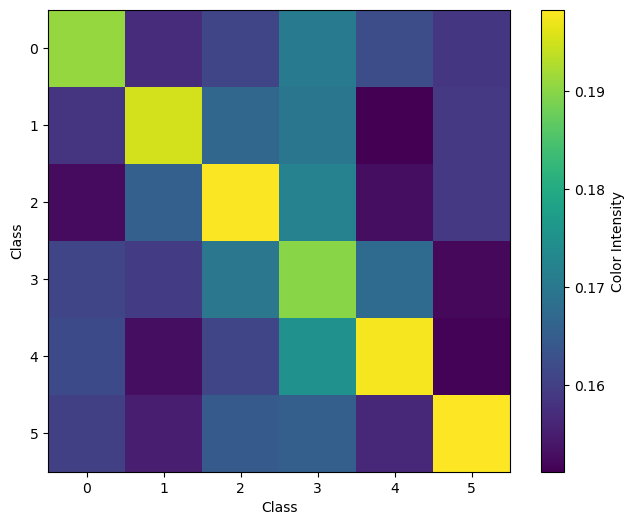

In [128]:
data=DHomophily_Matrix
# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Color Intensity')

# Add title and labels
#plt.title('Box Color Plot of a 2D Square Array')
plt.xlabel('Class')
plt.ylabel('Class')
plt.savefig("HOMO_Citeseer.png",bbox_inches="tight")
# Show the plot
plt.show()

# Texas

In [129]:
dataset = WebKB(root='/tmp/Texas', name='Texas')
data = dataset[0]
Number_nodes=len(data.y)
label=data.y.numpy()
Edge_idx=data.edge_index.numpy()
Node=range(Number_nodes)
Edgelist=[]
for i in range(len(Edge_idx[1])):
    Edgelist.append((Edge_idx[0][i],Edge_idx[1][i]))

print(data)
Node_class=[0,1,2,3,4]
F_vec=spatial_two(Node_class, Edgelist,Number_nodes)

Data(x=[183, 1703], edge_index=[2, 325], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10])


In [130]:
x =np.array(F_vec)
k=len(F_vec[0])
feature=[]
for i in range(len(x[0])):
    feature.append("{}".format(i))
data_s=pd.DataFrame(x,columns =feature)
data_s.insert(loc=k,column='class',value=label)
data_s.head()

,0,1,2,3,4,class
0,1,0,1,0,0,3
1,0,0,0,0,1,0
2,0,0,0,1,0,2
3,0,0,0,0,0,3
4,2,0,0,1,0,4


In [131]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
data_by_class = {cls: data_s.loc[data_s['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
Homophily_Matrix=[]
for i in range(5):
    df=data_by_class[i].div(data_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    Homophily_Matrix.append(column_avg)
print(Homophily_Matrix)
diagonal_elements = np.diag(Homophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Spatial Homophily_Ratio:", Homophily_Ratio)

[[0.03920118343195266, 0.0, 0.0040680473372781065, 0.46757889546351084, 0.48915187376725844], [0.0, 0.0, 1.0, 0.0, 0.0], [0.013333333333333334, 0.0, 0.07619047619047618, 0.6447619047619046, 0.2657142857142857], [0.13095238095238096, 0.0, 0.4841269841269841, 0.3611111111111111, 0.023809523809523808], [0.3192307692307692, 0.0, 0.26153846153846155, 0.3557692307692307, 0.06346153846153846]]
Spatial Homophily_Ratio: 0.10799286183901569


In [132]:
import pandas as pd
#dataset = Planetoid(root='/tmp/cora', name='Cora')
#data = dataset[0]
Domain_Fec=pd.DataFrame(data.x.numpy())
label=pd.DataFrame(data.y.numpy(),columns =['class'])
Data=pd.concat([Domain_Fec,label], axis=1)
Data.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=Data['class'].to_numpy()
data_by_class = {cls: Data.loc[Data['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
basis = [[max(df[i]) for i in range(len(df.columns))] for df in data_by_class.values()]
sel_basis = [[int(list(df[i].to_numpy()).count(1) >= int(len(df[i].index)*0.1)) 
              for i in range(len(df.columns))]
             for df in data_by_class.values()]
feature_names = [ii for ii in range(fe_len)]

In [133]:
Fec=[]
for i in range(Number_nodes):
#for i in range(2):
    vec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    vec.append(Similarity(f,basis[0]))
    vec.append(Similarity(f,basis[1]))
    vec.append(Similarity(f,basis[2]))
    vec.append(Similarity(f,basis[3]))
    vec.append(Similarity(f,basis[4]))
    f.clear()
    Fec.append(vec)
SFec=[]
for i in range(Number_nodes):
#for i in range(2):
    Svec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    Svec.append(Similarity(f,sel_basis[0]))
    Svec.append(Similarity(f,sel_basis[1]))
    Svec.append(Similarity(f,sel_basis[2]))
    Svec.append(Similarity(f,sel_basis[3]))
    Svec.append(Similarity(f,sel_basis[4]))
    f.clear()
    SFec.append(Svec)

In [134]:
Fec=np.array(Fec)
SFec=np.array(SFec)
domain=Fec+SFec
result=pd.DataFrame(domain)
result.insert(loc=k,column='class',value=data.y)
result.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
dataD_by_class = {cls: result.loc[result['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
DHomophily_Matrix=[]
for i in range(5):
    df=dataD_by_class[i].div(dataD_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    DHomophily_Matrix.append(column_avg)
print(DHomophily_Matrix)
diagonal_elements = np.diag(DHomophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Domain Homophily_Ratio:", Homophily_Ratio)

[[0.2550071284028333, 0.17687271930558293, 0.2027186117234876, 0.18560463195868923, 0.17979690860940684], [0.1909307875894988, 0.21479713603818615, 0.1957040572792363, 0.1957040572792363, 0.20286396181384247], [0.20133092325104715, 0.16991602421120758, 0.25606839470561665, 0.18336677521206962, 0.1893178826200589], [0.19980618412874482, 0.1832056450654206, 0.19982531153551658, 0.22024097531111356, 0.1969218839592045], [0.20015919763922516, 0.17427318026293884, 0.20391063557368388, 0.19128352801294454, 0.23037345851120752]]
Domain Homophily_Ratio: 0.2352974185937914


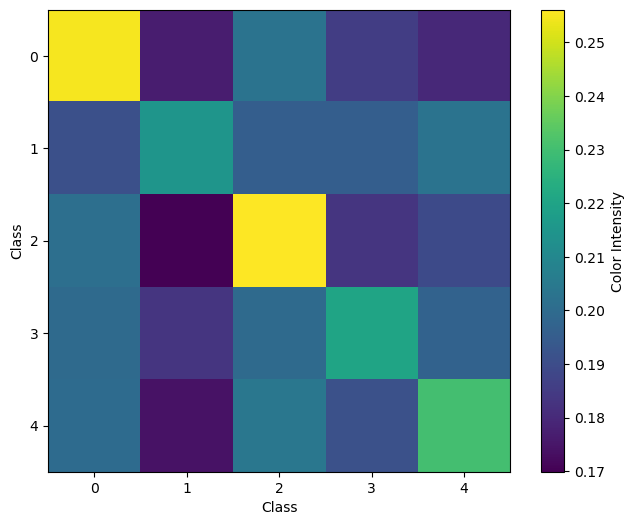

In [135]:
data=DHomophily_Matrix
# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Color Intensity')

# Add title and labels
#plt.title('Box Color Plot of a 2D Square Array')
plt.xlabel('Class')
plt.ylabel('Class')
plt.savefig("HOMO_Texas.png",bbox_inches="tight")
# Show the plot
plt.show()

# Cornell

In [107]:
dataset = WebKB(root='/tmp/Cornell', name='Cornell')
data = dataset[0]
Number_nodes=len(data.y)
label=data.y.numpy()
Edge_idx=data.edge_index.numpy()
Node=range(Number_nodes)
Edgelist=[]
for i in range(len(Edge_idx[1])):
    Edgelist.append((Edge_idx[0][i],Edge_idx[1][i]))

print(data)
Node_class=[0,1,2,3,4]
F_vec=spatial_two(Node_class, Edgelist,Number_nodes)

Data(x=[183, 1703], edge_index=[2, 298], y=[183], train_mask=[183, 10], val_mask=[183, 10], test_mask=[183, 10])


In [108]:
x =np.array(F_vec)
k=len(F_vec[0])
feature=[]
for i in range(len(x[0])):
    feature.append("{}".format(i))
data_s=pd.DataFrame(x,columns =feature)
data_s.insert(loc=k,column='class',value=label)
data_s.head()

,0,1,2,3,4,class
0,0,0,0,0,2,3
1,0,0,1,0,0,3
2,0,0,0,2,0,0
3,0,0,0,0,0,3
4,0,0,0,0,0,3


In [109]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
data_by_class = {cls: data_s.loc[data_s['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
Homophily_Matrix=[]
for i in range(5):
    df=data_by_class[i].div(data_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    Homophily_Matrix.append(column_avg)
print(Homophily_Matrix)
diagonal_elements = np.diag(Homophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Spatial Homophily_Ratio:", Homophily_Ratio)

[[0.04093158931868609, 0.002932551319648094, 0.25467928129218453, 0.6711535477664511, 0.030303030303030304], [0.09523809523809523, 0.21088435374149658, 0.07142857142857142, 0.2448979591836735, 0.37755102040816324], [0.19230769230769232, 0.03461538461538462, 0.0, 0.7038461538461538, 0.06923076923076923], [0.07407407407407407, 0.0, 0.3148148148148148, 0.5370370370370371, 0.07407407407407407], [0.0375, 0.221875, 0.27604166666666663, 0.33125000000000004, 0.13333333333333333]]
Spatial Homophily_Ratio: 0.1844372626861106


In [110]:
import pandas as pd
#dataset = Planetoid(root='/tmp/cora', name='Cora')
#data = dataset[0]
Domain_Fec=pd.DataFrame(data.x.numpy())
label=pd.DataFrame(data.y.numpy(),columns =['class'])
Data=pd.concat([Domain_Fec,label], axis=1)
Data.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=Data['class'].to_numpy()
data_by_class = {cls: Data.loc[Data['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
basis = [[max(df[i]) for i in range(len(df.columns))] for df in data_by_class.values()]
sel_basis = [[int(list(df[i].to_numpy()).count(1) >= int(len(df[i].index)*0.1)) 
              for i in range(len(df.columns))]
             for df in data_by_class.values()]
feature_names = [ii for ii in range(fe_len)]

In [111]:
Fec=[]
for i in range(Number_nodes):
#for i in range(2):
    vec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    vec.append(Similarity(f,basis[0]))
    vec.append(Similarity(f,basis[1]))
    vec.append(Similarity(f,basis[2]))
    vec.append(Similarity(f,basis[3]))
    vec.append(Similarity(f,basis[4]))
    f.clear()
    Fec.append(vec)
SFec=[]
for i in range(Number_nodes):
#for i in range(2):
    Svec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    Svec.append(Similarity(f,sel_basis[0]))
    Svec.append(Similarity(f,sel_basis[1]))
    Svec.append(Similarity(f,sel_basis[2]))
    Svec.append(Similarity(f,sel_basis[3]))
    Svec.append(Similarity(f,sel_basis[4]))
    f.clear()
    SFec.append(Svec)

In [112]:
Fec=np.array(Fec)
SFec=np.array(SFec)
domain=Fec+SFec
result=pd.DataFrame(domain)
result.insert(loc=k,column='class',value=data.y)
result.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
dataD_by_class = {cls: result.loc[result['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
DHomophily_Matrix=[]
for i in range(5):
    df=dataD_by_class[i].div(dataD_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    DHomophily_Matrix.append(column_avg)
print(DHomophily_Matrix)
diagonal_elements = np.diag(DHomophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Domain Homophily_Ratio:", Homophily_Ratio)

[[0.2444488311465535, 0.18848076627059496, 0.20310868062549645, 0.1820603566542278, 0.18190136530312737], [0.17129376156712955, 0.25476764847418004, 0.20743420300964663, 0.17536001193987022, 0.1911443750091736], [0.18055966231070666, 0.20766863139301414, 0.24834496329059866, 0.17644328992763764, 0.18698345307804284], [0.18903443240026502, 0.1973580590368134, 0.20897537134935865, 0.21409361133342672, 0.19053852588013623], [0.1806958542603131, 0.19858592701055694, 0.20226618076503278, 0.17514686232164342, 0.2433051756424538]]
Domain Homophily_Ratio: 0.24099204597744253


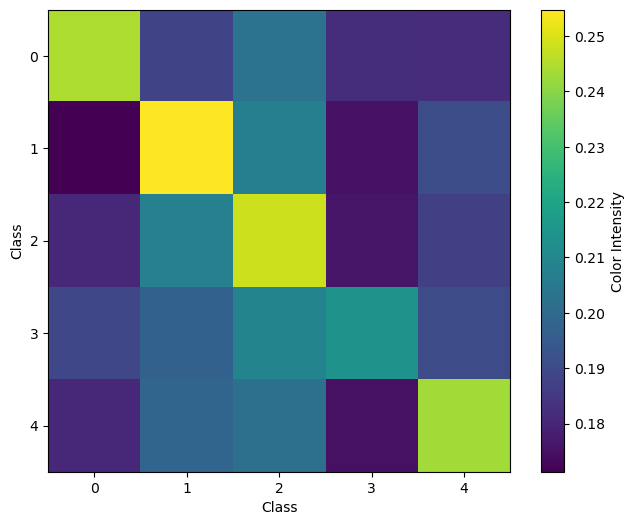

In [114]:
data=DHomophily_Matrix
# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Color Intensity')

# Add title and labels
#plt.title('Box Color Plot of a 2D Square Array')
plt.xlabel('Class')
plt.ylabel('Class')
plt.savefig("HOMO_Cornell.png",bbox_inches="tight")
# Show the plot
plt.show()

# Wisconsin

In [35]:
dataset = WebKB(root='/tmp/Wisconsin', name='Wisconsin')
data = dataset[0]
Number_nodes=len(data.y)
label=data.y.numpy()
Edge_idx=data.edge_index.numpy()
Node=range(Number_nodes)
Edgelist=[]
for i in range(len(Edge_idx[1])):
    Edgelist.append((Edge_idx[0][i],Edge_idx[1][i]))

print(data)
Node_class=[0,1,2,3,4]
F_vec=spatial_two(Node_class, Edgelist,Number_nodes)

Data(x=[251, 1703], edge_index=[2, 515], y=[251], train_mask=[251, 10], val_mask=[251, 10], test_mask=[251, 10])


In [36]:
x =np.array(F_vec)
k=len(F_vec[0])
feature=[]
for i in range(len(x[0])):
    feature.append("{}".format(i))
data_s=pd.DataFrame(x,columns =feature)
data_s.insert(loc=k,column='class',value=label)
data_s.head()

,0,1,2,3,4,class
0,0,3,2,0,0,1
1,0,0,0,0,0,2
2,0,0,0,1,0,2
3,0,2,0,0,0,2
4,0,0,1,0,0,1


In [37]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
data_by_class = {cls: data_s.loc[data_s['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
Homophily_Matrix=[]
for i in range(5):
    df=data_by_class[i].div(data_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    Homophily_Matrix.append(column_avg)
print(Homophily_Matrix)
diagonal_elements = np.diag(Homophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Spatial Homophily_Ratio:", Homophily_Ratio)

[[0.3333333333333333, 0.0, 0.0, 0.3333333333333333, 0.3333333333333333], [0.0007932310946589106, 0.21858993729697063, 0.5945160031225605, 0.1851753922087079, 0.0009254362771020624], [0.0, 0.5466101694915254, 0.22457627118644063, 0.14463276836158193, 0.08418079096045196], [0.043792517006802714, 0.2676020408163265, 0.4681122448979592, 0.07083333333333333, 0.14965986394557823], [0.14876543209876542, 0.03888888888888889, 0.3972222222222222, 0.19984567901234568, 0.21527777777777776]]
Spatial Homophily_Ratio: 0.21252213058557112


In [38]:
import pandas as pd
#dataset = Planetoid(root='/tmp/cora', name='Cora')
#data = dataset[0]
Domain_Fec=pd.DataFrame(data.x.numpy())
label=pd.DataFrame(data.y.numpy(),columns =['class'])
Data=pd.concat([Domain_Fec,label], axis=1)
Data.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=Data['class'].to_numpy()
data_by_class = {cls: Data.loc[Data['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
basis = [[max(df[i]) for i in range(len(df.columns))] for df in data_by_class.values()]
sel_basis = [[int(list(df[i].to_numpy()).count(1) >= int(len(df[i].index)*0.1)) 
              for i in range(len(df.columns))]
             for df in data_by_class.values()]
feature_names = [ii for ii in range(fe_len)]

In [39]:
Fec=[]
for i in range(Number_nodes):
#for i in range(2):
    vec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    vec.append(Similarity(f,basis[0]))
    vec.append(Similarity(f,basis[1]))
    vec.append(Similarity(f,basis[2]))
    vec.append(Similarity(f,basis[3]))
    vec.append(Similarity(f,basis[4]))
    f.clear()
    Fec.append(vec)
SFec=[]
for i in range(Number_nodes):
#for i in range(2):
    Svec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    Svec.append(Similarity(f,sel_basis[0]))
    Svec.append(Similarity(f,sel_basis[1]))
    Svec.append(Similarity(f,sel_basis[2]))
    Svec.append(Similarity(f,sel_basis[3]))
    Svec.append(Similarity(f,sel_basis[4]))
    f.clear()
    SFec.append(Svec)

In [40]:
Fec=np.array(Fec)
SFec=np.array(SFec)
domain=Fec+SFec
result=pd.DataFrame(domain)
result.insert(loc=k,column='class',value=data.y)
result.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
dataD_by_class = {cls: result.loc[result['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
DHomophily_Matrix=[]
for i in range(5):
    df=dataD_by_class[i].div(dataD_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    DHomophily_Matrix.append(column_avg)
print(DHomophily_Matrix)
diagonal_elements = np.diag(DHomophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Domain Homophily_Ratio:", Homophily_Ratio)

[[0.2532137804197614, 0.18593414821757973, 0.17961922951377568, 0.1945928688371584, 0.18663997301172489], [0.17036644916462104, 0.2547772721348568, 0.18929611805985333, 0.20163659363032718, 0.18392356701034163], [0.19154590457806817, 0.19558356061691184, 0.2117969270655551, 0.20750390805499888, 0.19356969968446586], [0.16859119113466453, 0.18380848368997607, 0.18390593890599713, 0.2554644669122331, 0.2082299193571293], [0.17132865390002353, 0.18755723257739357, 0.17570172746120521, 0.21586206791096157, 0.24955031815041617]]
Domain Homophily_Ratio: 0.24496055293656452


# Chameleon

In [85]:
dataset = WikipediaNetwork(root='/tmp/chameleon', name='chameleon')
data = dataset[0]
Number_nodes=len(data.y)
label=data.y.numpy()
Edge_idx=data.edge_index.numpy()
Node=range(Number_nodes)
Edgelist=[]
for i in range(len(Edge_idx[1])):
    Edgelist.append((Edge_idx[0][i],Edge_idx[1][i]))

print(data)
Node_class=[0,1,2,3,4]
F_vec=spatial_two(Node_class, Edgelist,Number_nodes)

Data(x=[2277, 2325], edge_index=[2, 36101], y=[2277], train_mask=[2277, 10], val_mask=[2277, 10], test_mask=[2277, 10])


In [86]:
x =np.array(F_vec)
k=len(F_vec[0])
feature=[]
for i in range(len(x[0])):
    feature.append("{}".format(i))
data_s=pd.DataFrame(x,columns =feature)
data_s.insert(loc=k,column='class',value=label)
data_s.head()

,0,1,2,3,4,class
0,3,2,0,0,0,0
1,0,1,5,4,7,3
2,1,3,2,7,7,3
3,0,0,1,0,0,4
4,0,0,2,0,2,2


In [87]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
data_by_class = {cls: data_s.loc[data_s['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
Homophily_Matrix=[]
for i in range(5):
    df=data_by_class[i].div(data_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    Homophily_Matrix.append(column_avg)
print(Homophily_Matrix)
diagonal_elements = np.diag(Homophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Spatial Homophily_Ratio:", Homophily_Ratio)

[[0.22186358483558197, 0.15363249970280451, 0.1059765238276925, 0.09462650645007817, 0.42390088518384306], [0.35327137784668033, 0.15449804567438327, 0.1234127631213621, 0.13666636254671582, 0.2321514508108581], [0.09594922255075278, 0.1359725452505029, 0.2152503587893443, 0.22280848175244908, 0.3300193916569514], [0.09925404954324972, 0.09815306312949613, 0.1874105994314992, 0.24481943600416087, 0.3703628518915946], [0.051967123604044964, 0.08054054830239644, 0.19581011328221892, 0.2331721706065729, 0.4385100442047674]]
Spatial Homophily_Ratio: 0.25498829390164757


In [88]:
import pandas as pd
#dataset = Planetoid(root='/tmp/cora', name='Cora')
#data = dataset[0]
Domain_Fec=pd.DataFrame(data.x.numpy())
label=pd.DataFrame(data.y.numpy(),columns =['class'])
Data=pd.concat([Domain_Fec,label], axis=1)
Data.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=Data['class'].to_numpy()
data_by_class = {cls: Data.loc[Data['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
basis = [[max(df[i]) for i in range(len(df.columns))] for df in data_by_class.values()]
sel_basis = [[int(list(df[i].to_numpy()).count(1) >= int(len(df[i].index)*0.1)) 
              for i in range(len(df.columns))]
             for df in data_by_class.values()]
feature_names = [ii for ii in range(fe_len)]

In [89]:
Fec=[]
for i in range(Number_nodes):
#for i in range(2):
    vec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    vec.append(Similarity(f,basis[0]))
    vec.append(Similarity(f,basis[1]))
    vec.append(Similarity(f,basis[2]))
    vec.append(Similarity(f,basis[3]))
    vec.append(Similarity(f,basis[4]))
    f.clear()
    Fec.append(vec)
SFec=[]
for i in range(Number_nodes):
#for i in range(2):
    Svec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    Svec.append(Similarity(f,sel_basis[0]))
    Svec.append(Similarity(f,sel_basis[1]))
    Svec.append(Similarity(f,sel_basis[2]))
    Svec.append(Similarity(f,sel_basis[3]))
    Svec.append(Similarity(f,sel_basis[4]))
    f.clear()
    SFec.append(Svec)

In [90]:
Fec=np.array(Fec)
SFec=np.array(SFec)
domain=Fec+SFec
result=pd.DataFrame(domain)
result.insert(loc=k,column='class',value=data.y)
result.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
dataD_by_class = {cls: result.loc[result['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
DHomophily_Matrix=[]
for i in range(5):
    df=dataD_by_class[i].div(dataD_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    DHomophily_Matrix.append(column_avg)
print(DHomophily_Matrix)
diagonal_elements = np.diag(DHomophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Domain Homophily_Ratio:", Homophily_Ratio)

[[0.23495207100704257, 0.18240553982080915, 0.1937808507475411, 0.19257902882914774, 0.19628250959545948], [0.15393595773037863, 0.24524032951093155, 0.19919187044850045, 0.19822912348886412, 0.20340271882132527], [0.1266549149430574, 0.16871397206335417, 0.2445960381230584, 0.22923504632792827, 0.23080002854260173], [0.11196332811323334, 0.15921453512770245, 0.2011976578188529, 0.28843285522099077, 0.23919162371922056], [0.11519332410058329, 0.1645841779992089, 0.212880577732443, 0.23830329059490757, 0.26903862957285757]]
Domain Homophily_Ratio: 0.25645198468697616


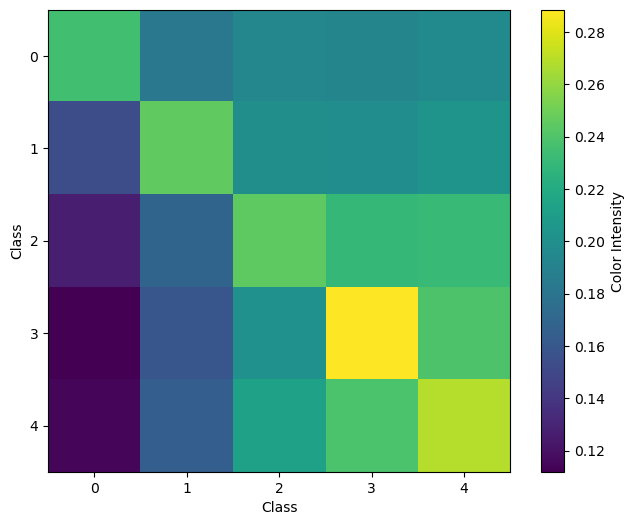

In [91]:
data=DHomophily_Matrix
# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Color Intensity')

# Add title and labels
#plt.title('Box Color Plot of a 2D Square Array')
plt.xlabel('Class')
plt.ylabel('Class')
plt.savefig("HOMO_CHAM.png",bbox_inches="tight")
# Show the plot
plt.show()

# Squeriell

In [11]:
dataset = WikipediaNetwork(root='/tmp/squirrel', name='squirrel')
data = dataset[0]
Number_nodes=len(data.y)
label=data.y.numpy()
Edge_idx=data.edge_index.numpy()
Node=range(Number_nodes)
Edgelist=[]
for i in range(len(Edge_idx[1])):
    Edgelist.append((Edge_idx[0][i],Edge_idx[1][i]))

print(data)
Node_class=[0,1,2,3,4]
F_vec=spatial_two(Node_class, Edgelist,Number_nodes)

Data(x=[5201, 2089], edge_index=[2, 217073], y=[5201], train_mask=[5201, 10], val_mask=[5201, 10], test_mask=[5201, 10])
Processing file 5200 (100%)

In [12]:
x =np.array(F_vec)
k=len(F_vec[0])
feature=[]
for i in range(len(x[0])):
    feature.append("{}".format(i))
data_s=pd.DataFrame(x,columns =feature)
data_s.insert(loc=k,column='class',value=label)
data_s.head()

,0,1,2,3,4,class
0,2121,3951,5565,5840,5232,1
1,10,19,15,34,30,3
2,110,150,179,195,188,0
3,2167,3978,5563,5848,5218,0
4,3,6,5,12,8,4


In [13]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
data_by_class = {cls: data_s.loc[data_s['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
Homophily_Matrix=[]
for i in range(5):
    df=data_by_class[i].div(data_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    Homophily_Matrix.append(column_avg)
print(Homophily_Matrix)
diagonal_elements = np.diag(Homophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Spatial Homophily_Ratio:", Homophily_Ratio)

[[0.1674660943874674, 0.17015582403663068, 0.19687846987790258, 0.2294286166678125, 0.23607099503018772], [0.13276972166385342, 0.19227130431354608, 0.19962108332098, 0.22869174948297594, 0.24664614121864492], [0.12091149692332442, 0.16762109551779844, 0.2360763415116842, 0.22557526171124734, 0.24981580433594663], [0.11857289193285947, 0.1579477007257598, 0.19704252565308292, 0.2609242961899508, 0.2655125854983478], [0.11800557739112197, 0.1517008878154286, 0.1933130569332452, 0.2298754937971788, 0.3071049840630261]]
Spatial Homophily_Ratio: 0.23276860409313488


In [14]:
data=Homophily_Matrix
# Convert each number to 3 decimal points
formatted_data = [[f'{num:.3f}' for num in row] for row in data]

# Convert the formatted data to a LaTeX table
latex_table = '\\begin{tabular}{|' + '|'.join(['c'] * len(formatted_data[0])) + '|}\n'
latex_table += '\\hline\n'
for row in formatted_data:
    latex_table += ' & '.join(row) + ' \\\\\n'
latex_table += '\\hline\n\\end{tabular}'

print(latex_table)

\begin{tabular}{|c|c|c|c|c|}
\hline
0.167 & 0.170 & 0.197 & 0.229 & 0.236 \\
0.133 & 0.192 & 0.200 & 0.229 & 0.247 \\
0.121 & 0.168 & 0.236 & 0.226 & 0.250 \\
0.119 & 0.158 & 0.197 & 0.261 & 0.266 \\
0.118 & 0.152 & 0.193 & 0.230 & 0.307 \\
\hline
\end{tabular}


In [79]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
data_by_class = {cls: data_s.loc[data_s['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
Homophily_Matrix=[]
for i in range(5):
    df=data_by_class[i].div(data_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    Homophily_Matrix.append(column_avg)
print(Homophily_Matrix)
diagonal_elements = np.diag(Homophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Spatial Homophily_Ratio:", Homophily_Ratio)

[[0.1471624195686311, 0.14554193959441708, 0.1537109991120441, 0.21309763756752476, 0.340487004157383], [0.13198402954082605, 0.1615784106209285, 0.1734158252025866, 0.2211962218941667, 0.311825512741493], [0.10380049329620912, 0.15594860752802428, 0.19388054307415498, 0.23266953594658574, 0.31370082015502676], [0.10637557994747614, 0.1455577044178291, 0.17609120033320635, 0.2516830285915665, 0.32029248670992294], [0.10589997558779037, 0.1392168828047496, 0.17837804551372738, 0.2356887978874737, 0.34081629820625936]]
Spatial Homophily_Ratio: 0.21902414001230808


In [80]:
import pandas as pd
#dataset = Planetoid(root='/tmp/cora', name='Cora')
#data = dataset[0]
Domain_Fec=pd.DataFrame(data.x.numpy())
label=pd.DataFrame(data.y.numpy(),columns =['class'])
Data=pd.concat([Domain_Fec,label], axis=1)
Data.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=Data['class'].to_numpy()
data_by_class = {cls: Data.loc[Data['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
basis = [[max(df[i]) for i in range(len(df.columns))] for df in data_by_class.values()]
sel_basis = [[int(list(df[i].to_numpy()).count(1) >= int(len(df[i].index)*0.01)) 
              for i in range(len(df.columns))]
             for df in data_by_class.values()]
feature_names = [ii for ii in range(fe_len)]

In [81]:
Fec=[]
for i in range(Number_nodes):
#for i in range(2):
    vec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    vec.append(Similarity(f,basis[0]))
    vec.append(Similarity(f,basis[1]))
    vec.append(Similarity(f,basis[2]))
    vec.append(Similarity(f,basis[3]))
    vec.append(Similarity(f,basis[4]))
    f.clear()
    Fec.append(vec)
SFec=[]
for i in range(Number_nodes):
#for i in range(2):
    Svec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    Svec.append(Similarity(f,sel_basis[0]))
    Svec.append(Similarity(f,sel_basis[1]))
    Svec.append(Similarity(f,sel_basis[2]))
    Svec.append(Similarity(f,sel_basis[3]))
    Svec.append(Similarity(f,sel_basis[4]))
    f.clear()
    SFec.append(Svec)

In [82]:
Fec=np.array(Fec)
SFec=np.array(SFec)
domain=Fec+SFec
result=pd.DataFrame(domain)
result.insert(loc=k,column='class',value=data.y)
result.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
dataD_by_class = {cls: result.loc[result['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
DHomophily_Matrix=[]
for i in range(5):
    df=dataD_by_class[i].div(dataD_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    DHomophily_Matrix.append(column_avg)
print(DHomophily_Matrix)
diagonal_elements = np.diag(DHomophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Domain Homophily_Ratio:", Homophily_Ratio)

[[0.17374996258248376, 0.1873140013557796, 0.2031717876662814, 0.21230124474335751, 0.2234630036520977], [0.16383740171884073, 0.19429536640525144, 0.20451593703809257, 0.21379869507406174, 0.22355259976375352], [0.16461201065951545, 0.1880928552440368, 0.20953247121812626, 0.21432593067190975, 0.22343673220641175], [0.16215361044518783, 0.1872806040448389, 0.20508608487428678, 0.21955390517988504, 0.22592579545580138], [0.16112498359647345, 0.18638209658795654, 0.2050836666366651, 0.21592381772662636, 0.23148543545227887]]
Domain Homophily_Ratio: 0.20572342816760508


In [2]:
data=[[0.17374996258248376, 0.1873140013557796, 0.2031717876662814, 0.21230124474335751, 0.2234630036520977], [0.16383740171884073, 0.19429536640525144, 0.20451593703809257, 0.21379869507406174, 0.22355259976375352], [0.16461201065951545, 0.1880928552440368, 0.20953247121812626, 0.21432593067190975, 0.22343673220641175], [0.16215361044518783, 0.1872806040448389, 0.20508608487428678, 0.21955390517988504, 0.22592579545580138], [0.16112498359647345, 0.18638209658795654, 0.2050836666366651, 0.21592381772662636, 0.23148543545227887]]
# Convert each number to 3 decimal points
formatted_data = [[f'{num:.3f}' for num in row] for row in data]

# Convert the formatted data to a LaTeX table
latex_table = '\\begin{tabular}{|' + '|'.join(['c'] * len(formatted_data[0])) + '|}\n'
latex_table += '\\hline\n'
for row in formatted_data:
    latex_table += ' & '.join(row) + ' \\\\\n'
latex_table += '\\hline\n\\end{tabular}'

print(latex_table)

\begin{tabular}{|c|c|c|c|c|}
\hline
0.174 & 0.187 & 0.203 & 0.212 & 0.223 \\
0.164 & 0.194 & 0.205 & 0.214 & 0.224 \\
0.165 & 0.188 & 0.210 & 0.214 & 0.223 \\
0.162 & 0.187 & 0.205 & 0.220 & 0.226 \\
0.161 & 0.186 & 0.205 & 0.216 & 0.231 \\
\hline
\end{tabular}


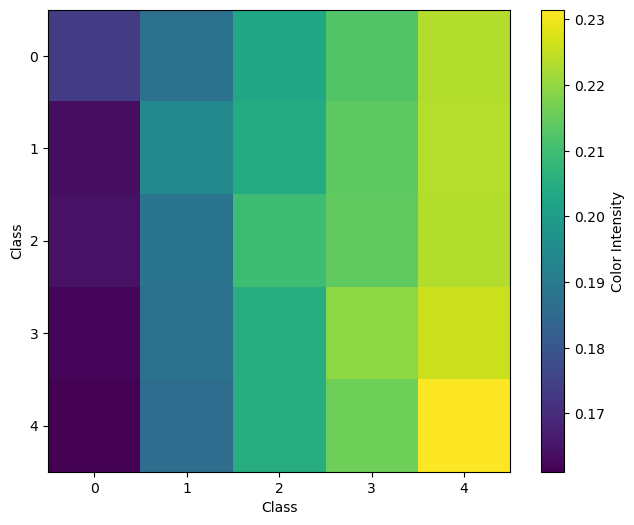

In [84]:
data=DHomophily_Matrix
# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Color Intensity')

# Add title and labels
#plt.title('Box Color Plot of a 2D Square Array')
plt.xlabel('Class')
plt.ylabel('Class')
plt.savefig("HOMO_SQUI.png",bbox_inches="tight")
# Show the plot
plt.show()

# Pubmed

In [71]:
dataset = Planetoid(root='/tmp/PubMed', name='PubMed')
data = dataset[0]
Number_nodes=len(data.y)
label=data.y.numpy()
Edge_idx=data.edge_index.numpy()
Node=range(Number_nodes)
Edgelist=[]
for i in range(len(Edge_idx[1])):
    Edgelist.append((Edge_idx[0][i],Edge_idx[1][i]))

print(data)
Node_class=[0,1,2]
F_vec=spatial_two(Node_class, Edgelist,Number_nodes)


Data(x=[19717, 500], edge_index=[2, 88648], y=[19717], train_mask=[19717], val_mask=[19717], test_mask=[19717])


In [72]:
x =np.array(F_vec)
k=len(F_vec[0])
feature=[]
for i in range(len(x[0])):
    feature.append("{}".format(i))
data_s=pd.DataFrame(x,columns =feature)
data_s.insert(loc=k,column='class',value=label)
data_s.head()

,0,1,2,class
0,0,5,0,1
1,0,3,0,1
2,2,0,1,0
3,0,0,1,2
4,1,0,0,1


In [73]:
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
data_by_class = {cls: data_s.loc[data_s['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
Homophily_Matrix=[]
for i in range(3):
    df=data_by_class[i].div(data_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    Homophily_Matrix.append(column_avg)
print(Homophily_Matrix)
diagonal_elements = np.diag(Homophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Spatial Homophily_Ratio:", Homophily_Ratio)

[[0.6912405097298931, 0.12186457459962186, 0.18689491567048563], [0.05016723892101139, 0.8525783086546667, 0.0972544524243228], [0.08358345863487457, 0.13041904956219247, 0.7859974918029343]]
Spatial Homophily_Ratio: 0.7766054367291647


In [74]:
import pandas as pd

Domain_Fec=pd.DataFrame(data.x.numpy())
label=pd.DataFrame(data.y.numpy(),columns =['class'])
Data=pd.concat([Domain_Fec,label], axis=1)
Data.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data.y.numpy()
data_by_class = {cls: Data.loc[Data['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
import numpy as np
def Average(lst):
    # average function
    avg = np.average(lst)
    return(avg)
sel_basis = [[Average(list(df[i].to_numpy())) for i in range(len(df.columns))]for df in data_by_class.values()]
feature_names = [ii for ii in range(fe_len)]
Fec=[]
for i in range(Number_nodes):
    print("\rProcessing file {} ({}%)".format(i, 100*i//(Number_nodes-1)), end='', flush=True)
    vec=[]
    f=Data.loc[i, feature_names].values.flatten().tolist()
    for j in range(max(catagories)+1):
        vec.append(np.linalg.norm(np.array(f) - np.array(sel_basis[j])))
    f.clear()
    Fec.append(vec)


Processing file 19716 (100%)

In [75]:
result=pd.DataFrame(Fec)
result.insert(loc=k,column='class',value=data.y)
result.head()
Number_nodes=len(data.y)
fe_len=len(data.x[0])
catagories=data_s['class'].to_numpy()
dataD_by_class = {cls: result.loc[result['class'] == cls].drop(['class'], axis=1) for cls in range(max(catagories) + 1)}
DHomophily_Matrix=[]
for i in range(3):
    df=dataD_by_class[i].div(dataD_by_class[i].sum(axis=1), axis=0)
    column_avg = df.mean().tolist()
    DHomophily_Matrix.append(column_avg)
print(DHomophily_Matrix)
diagonal_elements = np.diag(DHomophily_Matrix)
Homophily_Ratio=np.mean(diagonal_elements)

print("Domain Homophily_Ratio:", Homophily_Ratio)

[[0.32392676083830074, 0.33799322922027186, 0.3380800099414274], [0.3452569066281109, 0.32275915972638425, 0.3319839336455048], [0.34239627136837686, 0.33091260926721544, 0.32669111936440764]]
Domain Homophily_Ratio: 0.32445901330969756


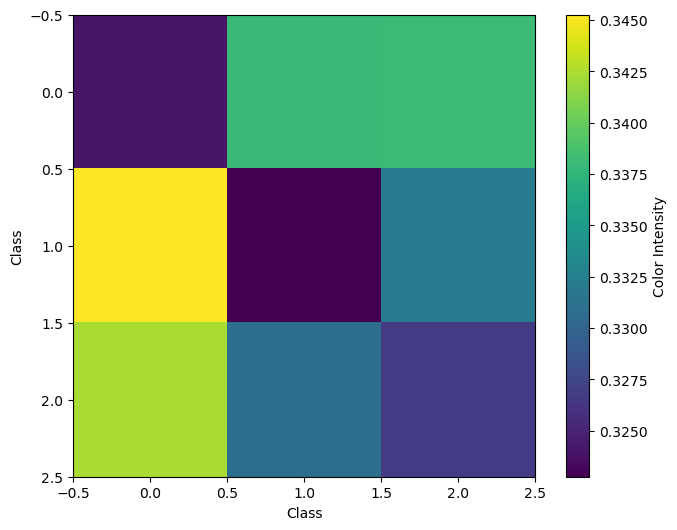

In [76]:
data=DHomophily_Matrix
# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Color Intensity')

# Add title and labels
#plt.title('Box Color Plot of a 2D Square Array')
plt.xlabel('Class')
plt.ylabel('Class')

# Show the plot
plt.show()

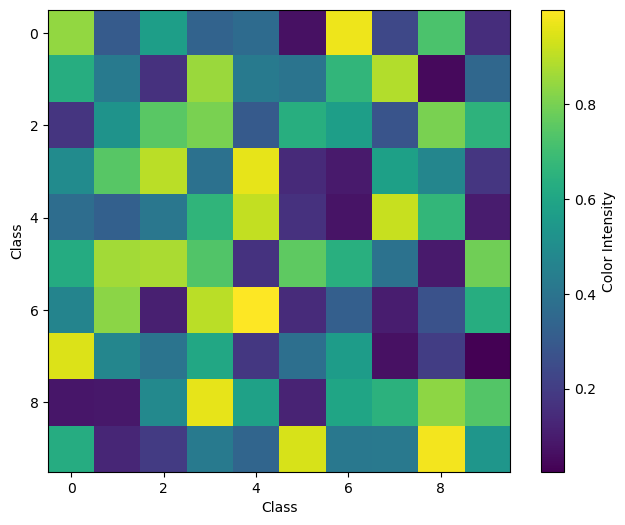

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data (2D square array)
data = np.random.rand(10, 10)

# Create the plot
plt.figure(figsize=(8, 6))
plt.imshow(data, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Color Intensity')

# Add title and labels
#plt.title('Box Color Plot of a 2D Square Array')
plt.xlabel('Class')
plt.ylabel('Class')

# Show the plot
plt.show()
